# Fraud in Mobile Money Transactions
PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

# Libraries

In [1]:
# allows us to ignore warnings, since they are just warnings 
import warnings
warnings.filterwarnings('ignore')

# allows us to print things in jupyter in a pretty way
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# import pandas to be able to use dataframes
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# import plotting library
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# allow inline plotting on notebook cells
%matplotlib inline

# we'll get access to the numpy library
import numpy as np

# We'll use a label encoder to convert categorical feature to numerical values
from sklearn.preprocessing import LabelEncoder

# install using: pip install outlier_utils
# univariate anomaly detection
from outliers import smirnov_grubbs as grubbs

# Access to the localoutlierfactor for clustering
from sklearn.neighbors import LocalOutlierFactor

# allows us to implement a train test split strategy
from sklearn.model_selection import train_test_split

# access to the logistic regression class of Sklearn
from sklearn.linear_model import LogisticRegression

# access to the neural network model MLP Classifier
from sklearn.neural_network import MLPClassifier

# classification metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# feature power transformation functions
from scipy.stats import boxcox

# normality tests
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import probplot


# Exploration

In [2]:
# https://www.kaggle.com/ntnu-testimon/paysim1/download
# download archive.zip file and place in data/ folder 
data_df = pd.read_csv('data/archive.zip')

In [3]:
data_df.shape

(6362620, 11)

In [4]:
# Let's fix some of the columns 
data_df = data_df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

# Header
This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [5]:
# Let's have a quick view of the dataset
tmp_df = data_df.head(1).T
tmp_df.columns = ['sample']
tmp_df['dtypes'] = data_df.dtypes
tmp_df

,sample,dtypes
step,1,int64
type,PAYMENT,object
amount,9839.640000,float64
nameOrig,C1231006815,object
oldBalanceOrig,170136.000000,float64
newBalanceOrig,160296.360000,float64
nameDest,M1979787155,object
oldBalanceDest,0.000000,float64
newBalanceDest,0.000000,float64
isFraud,0,int64


In [6]:
# Do we have rows that have any null values?
data_df.isnull().values.any()

False

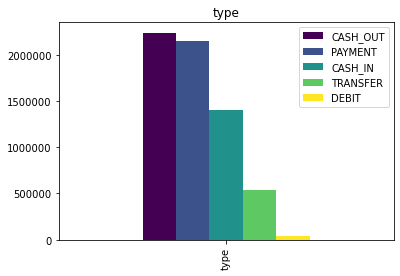

In [7]:
# Let's try to better understand our data

col = 'type'
series = data_df[col]
tmp_df = pd.DataFrame(series.value_counts())
tmp_df = tmp_df.T


tmp_df.plot.bar(title=col,cmap="viridis")
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.show()

In [8]:
tmp_df = data_df['amount']
tmp_df.describe()

count    6362620.000000
mean      179861.903549
std       603858.231463
min            0.000000
25%        13389.570000
50%        74871.940000
75%       208721.477500
max     92445516.640000
Name: amount, dtype: float64

<AxesSubplot:>

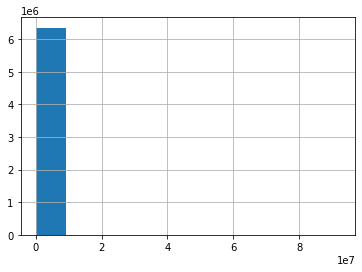

In [9]:
tmp_df.hist()

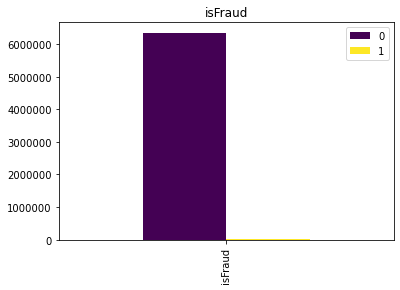

In [10]:
col = 'isFraud'
series = data_df[col]
tmp_df = pd.DataFrame(series.value_counts())
tmp_df = tmp_df.T


tmp_df.plot.bar(title=col,cmap="viridis")
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.show()

In [11]:
# There is a large imbalance between the two classes
display(tmp_df)

,0,1
isFraud,6354407,8213


In [12]:
# Let's revisit the exploration but with respect to each payment type

In [13]:
col = 'type'
tmp_s = data_df[col]
tmp_list = tmp_s.unique()

for i in tmp_list:
    printmd("***"+i+"***")
    
    tmp_df = data_df[data_df['type']==i]
    display(tmp_df.describe()[['amount']].T)
    
    # fraud
    display(pd.DataFrame(tmp_df['isFraud'].value_counts()))
    
    # merchant vs regular customer
    
    # origin
    
    orig = {'regular': tmp_df[tmp_df.nameOrig.str.contains('C')].drop_duplicates().shape[0], 
             'merchant': tmp_df[tmp_df.nameOrig.str.contains('M')].drop_duplicates().shape[0]}
    dest = {'regular': tmp_df[tmp_df.nameDest.str.contains('C')].drop_duplicates().shape[0], 
             'merchant': tmp_df[tmp_df.nameDest.str.contains('M')].drop_duplicates().shape[0]}
    
    txn = [orig, dest]
    
    txn_df = pd.DataFrame(txn)
    txn_df.index = ["orig","dest"]
    
    display(txn_df)
  

***PAYMENT***

,count,mean,std,min,25%,50%,75%,max
amount,2151495.000000,13057.604660,12556.450186,0.020000,4383.820000,9482.190000,17561.220000,238637.980000


,isFraud
0,2151495


,regular,merchant
orig,2151495,0
dest,0,2151495


***TRANSFER***

,count,mean,std,min,25%,50%,75%,max
amount,532909.000000,910647.009645,1879573.528908,2.600000,215905.350000,486308.390000,974958.000000,92445516.640000


,isFraud
0,528812
1,4097


,regular,merchant
orig,532909,0
dest,532909,0


***CASH_OUT***

,count,mean,std,min,25%,50%,75%,max
amount,2237500.000000,176273.964346,175329.744483,0.000000,72669.650000,147072.185000,246539.477500,10000000.000000


,isFraud
0,2233384
1,4116


,regular,merchant
orig,2237500,0
dest,2237500,0


***DEBIT***

,count,mean,std,min,25%,50%,75%,max
amount,41432.000000,5483.665314,13318.535518,0.550000,1500.180000,3048.990000,5479.175000,569077.510000


,isFraud
0,41432


,regular,merchant
orig,41432,0
dest,41432,0


***CASH_IN***

,count,mean,std,min,25%,50%,75%,max
amount,1399284.000000,168920.242004,126508.255272,0.040000,70510.182500,143427.710000,239899.087500,1915267.900000


,isFraud
0,1399284


,regular,merchant
orig,1399284,0
dest,1399284,0


Looks like most frauds occured in Transfer and cash out and with regular customers

In [14]:
# Let's look at consistency of balance within transactions before and after

# this should result to zero for a balanced transaction
data_df['errorOrig'] = (data_df['newBalanceOrig']+data_df['amount'])-data_df['oldBalanceOrig']
data_df['errorDest'] = (data_df['oldBalanceDest']+data_df['amount'])-data_df['newBalanceDest']

# what is the percentage of transactions with non-balanced (non ZERO) transactions?
print("% of orig txns with non zero error balance: ",data_df[data_df['errorOrig']!=0]['errorOrig'].count()/data_df['errorOrig'].shape[0])
print("% of dest txns with non zero error balance: ",data_df[data_df['errorDest']!=0]['errorDest'].count()/data_df['errorDest'].shape[0])

# how does it look like broken down by payment types?
print()
print("% of orig txns w/ non zero error balance by payment type")
tmp_df = data_df[data_df['errorOrig']!=0].groupby(['type']).count()['errorOrig']/data_df.groupby(['type']).count()['errorOrig']
tmp_df = pd.DataFrame(tmp_df)
display(tmp_df)

print("% of dest txns w/ non zero error balance by payment type")
tmp_df = data_df[data_df['errorDest']!=0].groupby(['type']).count()['errorDest']/data_df.groupby(['type']).count()['errorDest']
tmp_df = pd.DataFrame(tmp_df)
display(tmp_df)

# what about by fraud indicator?
print("% of orig txns w/ non zero error balance by fraud ind")
tmp_df = data_df[data_df['errorOrig']!=0].groupby(['isFraud']).count()['errorOrig']/data_df.groupby(['isFraud']).count()['errorOrig']
tmp_df = pd.DataFrame(tmp_df)
display(tmp_df)

print("% of dest txns w/ non zero error balance by fraud ind")
tmp_df = data_df[data_df['errorDest']!=0].groupby(['isFraud']).count()['errorDest']/data_df.groupby(['isFraud']).count()['errorDest']
tmp_df = pd.DataFrame(tmp_df)
display(tmp_df)

% of orig txns with non zero error balance:  0.8192331146603129
% of dest txns with non zero error balance:  0.7444533855550072

% of orig txns w/ non zero error balance by payment type


,errorOrig
type,
CASH_IN,1.000000
CASH_OUT,0.898052
DEBIT,0.329962
PAYMENT,0.594509
TRANSFER,0.958963


% of dest txns w/ non zero error balance by payment type


,errorDest
type,
CASH_IN,1.000000
CASH_OUT,0.417347
DEBIT,0.475743
PAYMENT,1.000000
TRANSFER,0.436039


% of orig txns w/ non zero error balance by fraud ind


,errorOrig
isFraud,
0,0.820283
1,0.006940


% of dest txns w/ non zero error balance by fraud ind


,errorDest
isFraud,
0,0.744578
1,0.648241


It seems in general having non zero error balance between transactions does not indicate any fraud behavior except for destination accounts which has higher than normal of 64% identified as fraud

In [15]:
# how many unique fraud customers can be found in Cash out and transfer type transactions?
data_df.groupby(['isFraud','type']).nunique()[['nameOrig','nameDest']]

nameOrig  nameDest
isFraud type                        
0       CASH_IN    1398845    446789
        CASH_OUT   2232246    488215
        DEBIT        41432     38533
        PAYMENT    2150401   2150401
        TRANSFER    528744    233686
1       CASH_OUT      4116      4091
        TRANSFER      4097      4097

In [16]:
fraud_df = data_df[data_df['isFraud']==1]
notfraud_df = data_df[data_df['isFraud']==0]

In [17]:
# Are there any relationships within the customers and merchants that conducted fraud?

fraudorig_set = set(fraud_df['nameOrig'].values) #convert series to array then set (unique) 
frauddest_set = set(fraud_df['nameDest'].values) #convert series to array then set (unique)
fraudcombined_set = fraudorig_set.union(frauddest_set) #combine both into one set

notfraudorig_set = set(notfraud_df['nameOrig'].values) #convert series to array then set (unique) 
notfrauddest_set = set(notfraud_df['nameDest'].values) #convert series to array then set (unique)
notfraudcombined_set = notfraudorig_set.union(notfrauddest_set) #combine both into one set

In [18]:
print("Total unique customer count: ", len(fraudcombined_set.union(notfraudcombined_set)))
print("Customers involved in fraud: ",len(fraudcombined_set))
print("Customers NOT involved in fraud: ",len(notfraudcombined_set))
print("Originating Customers in Txns: ", len(fraudorig_set.union(notfraudorig_set)))
print("Destination Customers in Txns: ", len(frauddest_set.union(notfrauddest_set)))
print("Count of customers that originated in fraud transactions: ",len(fraudorig_set))
print("How many of those customers are regular customers? ",len([i for i in fraudorig_set if 'C' in i]))
print("How many of those customers are merchant customers? ", len([i for i in fraudorig_set if 'M' in i]))
print("Count of customers that is the destination in fraud transactions: ",len(frauddest_set))
print("How many of those customers are regular customers? ",len([i for i in frauddest_set if 'C' in i]))
print("How many of those customers are merchant customers? ", len([i for i in frauddest_set if 'M' in i]))
print("how many Fraud customers showed up in BOTH orig and dest? ", len(frauddest_set.intersection(fraudorig_set)))


Total unique customer count:  9073900
Customers involved in fraud:  16382
Customers NOT involved in fraud:  9063043
Originating Customers in Txns:  6353307
Destination Customers in Txns:  2722362
Count of customers that originated in fraud transactions:  8213
How many of those customers are regular customers?  8213
How many of those customers are merchant customers?  0
Count of customers that is the destination in fraud transactions:  8169
How many of those customers are regular customers?  8169
How many of those customers are merchant customers?  0
how many Fraud customers showed up in BOTH orig and dest?  0


In [19]:
print("Did any fraud orig customers show up in legitimate transactions? ")
print("How many transactions as originating customers? ", data_df[(data_df['nameOrig'].isin(fraudorig_set)) & (data_df['isFraud']==0)].shape[0])
print("How many unique ids showed up as originating customers: ", len(fraudorig_set.intersection(notfraudorig_set)))
print("How many transactions as destination customers? ", data_df[(data_df['nameDest'].isin(fraudorig_set)) & (data_df['isFraud']==0)].shape[0])
print("How many unique ids showed up as destination customers: ", len(fraudorig_set.intersection(notfrauddest_set)))
print("")
print("Did any fraud dest customers show up in legitimate transactions? ")
print("How many transactions as originating customers? ", data_df[(data_df['nameOrig'].isin(frauddest_set)) & (data_df['isFraud']==0)].shape[0])
print("How many unique ids showed up as originating customers: ", len(frauddest_set.intersection(notfraudorig_set)))
print("How many transactions as destination customers? ", data_df[(data_df['nameDest'].isin(frauddest_set)) & (data_df['isFraud']==0)].shape[0])
print("How many unique ids showed up as destination customers: ", len(frauddest_set.intersection(notfrauddest_set)))


Did any fraud orig customers show up in legitimate transactions? 
How many transactions as originating customers?  28
How many unique ids showed up as originating customers:  28
How many transactions as destination customers?  0
How many unique ids showed up as destination customers:  0

Did any fraud dest customers show up in legitimate transactions? 
How many transactions as originating customers?  18
How many unique ids showed up as originating customers:  18
How many transactions as destination customers?  57435
How many unique ids showed up as destination customers:  5492


In [20]:
tmp_df = pd.DataFrame()
tmp_df['fraud'] = fraud_df.amount.describe().T
tmp_df['notfraud'] = notfraud_df.amount.describe().T
display(tmp_df.T)

,count,mean,std,min,25%,50%,75%,max
fraud,8213.000000,1467967.299140,2404252.947240,0.000000,127091.330000,441423.440000,1517771.480000,10000000.000000
notfraud,6354407.000000,178197.041727,596236.981347,0.010000,13368.395000,74684.720000,208364.760000,92445516.640000


# Preprocessing

In [21]:
# do we still have any null values?
data_df.isnull().values.any()

False

In [22]:
enc = LabelEncoder()
data_df['type_num'] = enc.fit_transform(data_df['type'])
data_df['type_num'] = data_df['type_num'].apply(lambda x: np.int64(x))

In [23]:
# Let's remove the customer names since we won't be needing them for training

training_df = data_df.drop(['nameOrig','nameDest','isFlaggedFraud','type'], axis=1)


In [24]:
training_df.head()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,errorOrig,errorDest,type_num
0,1,9839.640000,170136.000000,160296.360000,0.000000,0.000000,0,0.000000,9839.640000,3
1,1,1864.280000,21249.000000,19384.720000,0.000000,0.000000,0,0.000000,1864.280000,3
2,1,181.000000,181.000000,0.000000,0.000000,0.000000,1,0.000000,181.000000,4
3,1,181.000000,181.000000,0.000000,21182.000000,0.000000,1,0.000000,21363.000000,1
4,1,11668.140000,41554.000000,29885.860000,0.000000,0.000000,0,0.000000,11668.140000,3


In [25]:
training_df.dtypes

step                int64
amount            float64
oldBalanceOrig    float64
newBalanceOrig    float64
oldBalanceDest    float64
newBalanceDest    float64
isFraud             int64
errorOrig         float64
errorDest         float64
type_num            int64
dtype: object

# Anomaly Detection
## via Clustering

Unsupervised Outlier Detection using Local Outlier Factor (LOF)

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.

In [26]:
y = training_df.isFraud
X = training_df.drop(['isFraud'],axis=1)

In [27]:
%%time

lof_model = LocalOutlierFactor(n_neighbors=2)
y_pred = lof_model.fit_predict(X)




Wall time: 2h 40min 11s


In [28]:
# lof works by tagging inliers with 1 and outliers by -1
y_pred

array([ 1,  1,  1, ...,  1,  1, -1])

In [29]:
# Let's try to create a dataframe to see how it looks like

tmp_df = training_df.copy()
tmp_df['anomaly'] = y_pred
tmp_df['anomaly'] = tmp_df['anomaly'].apply(lambda x: 1 if(x == -1) else 0)
tmp_df[['isFraud','anomaly','step']].groupby(['isFraud','anomaly']).count()


step
isFraud anomaly         
0       0        5839300
        1         515107
1       0           7199
        1           1014

In [32]:


# Let's save our results in a variable for later use
y_pred_lof = tmp_df['anomaly']
y_test = tmp_df['isFraud']

print("accuracy: ",accuracy_score(y_test,y_pred_lof))
print("precision_score: ",precision_score(y_test,y_pred_lof))
print("recall_score: ",recall_score(y_test,y_pred_lof))
print("confusion matrix: ")
confusion_matrix(y_test,y_pred_lof)

accuracy:  0.9179102319484741
precision_score:  0.0019646555749523852
recall_score:  0.12346280287349325
confusion matrix: 


array([[5839300,  515107],
       [   7199,    1014]], dtype=int64)

No Skill: ROC AUC=0.500
LocalOutlierFactor: ROC AUC=0.521


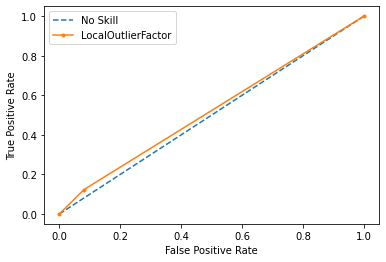

In [33]:


# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(tmp_df['isFraud']))]
lr_probs = y_pred_lof
# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(tmp_df['isFraud'], ns_probs)
lr_auc = roc_auc_score(tmp_df['isFraud'], lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LocalOutlierFactor: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(tmp_df['isFraud'], ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(tmp_df['isFraud'], lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LocalOutlierFactor')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Notice that the accuracy 'seems' misleading as we are looking at a fraud use case which indicates an imbalance on true positive classifications. Taking a look at the precision and recall metrics would give us a better view of how our anomaly detection is performing.

## via Grubb's Test

Grubbs’ Test is used to identify the presence of outliers in a dataset. To use this test, a dataset should be approximately normally distributed and have at least 7 observations. Grubbs's test is based on the assumption of **normality**. That is, one should first verify that the data can be reasonably approximated by a normal distribution before applying the Grubbs test.

https://en.wikipedia.org/wiki/Grubbs%27s_test

**For purposes of demonstration we will only use ONE FEATURE to show case the tests**

'Before'

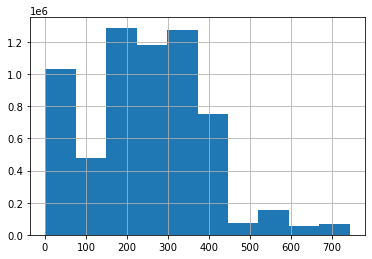

'After'

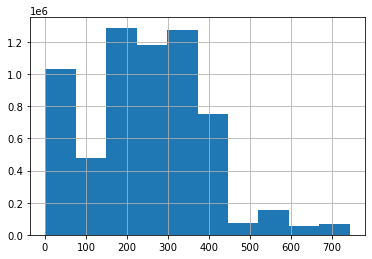

In [34]:
# we will look at two classes of techniques for checking whether a sample of data is Gaussian:

# Graphical Methods. These are methods for plotting the data and qualitatively evaluating whether the data looks Gaussian.
# Statistical Tests. These are methods that calculate statistics on the data and quantify how likely it is that
# the data was drawn from a Gaussian distribution. Methods of this type are often called normality tests.

# via Graphical - We assume that plotting our data set would result to what would look like a 'normal' distribution

# histogram - is an approximate representation of the distribution of numerical data

series_tmp = training_df['step'].copy()
display("Before")
series_tmp.hist()
plt.show()
# you can see here that our distribution skews to the left which is different to the bellcurve of a normal/gaussian distribution

# To address this, we use a power transformation and try to make our dataset look normal/gaussian
# The Boxcox function accepts a lambda parameter that dictates what transformation to do
# In this case a lambda value of .5 means it will do a square root transformation to all of the data set
boxcox_series_tmp = pd.Series(boxcox(series_tmp,0.5))
display("After")
series_tmp.hist()
plt.show()

# You can see here that our data set is now more 'gaussian' like

'Before'

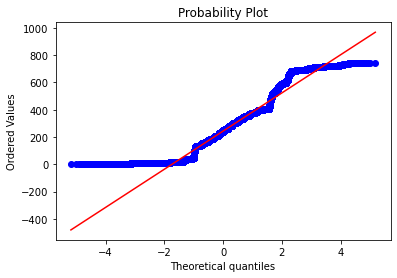

'After'

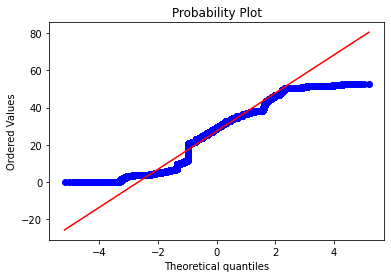

In [35]:
# The Q-Q plot, or quantile-quantile plot, is a graphical tool to help us assess if
# a set of data plausibly came from some theoretical distribution such as a Normal or exponential. 

display("Before")
probplot(series_tmp, dist="norm", plot=plt)
plt.show()

# You can see that our data set does not completely fit our plot, so we apply the same power transformation

display("After")

probplot(boxcox_series_tmp, dist="norm", plot=plt)
plt.show()

# We plot the data set again and see a minor visual improvements to the qq plot


In [36]:
# The next tests validate by generating a statistic called p value 
# Technically this is called the null hypothesis, or H0. A threshold level is chosen called alpha, 
# typically 5% (or 0.05), that is used to interpret the p-value.

# In the SciPy implementation of these tests, you can interpret the p value as follows.

# p <= alpha: reject H0, not normal.
# p > alpha: fail to reject H0, normal.



print("Using Shapiro Normality Test")
print("Before: ")
print(shapiro(series_tmp))

print("After")
print(shapiro(boxcox_series_tmp))

# The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a
# Gaussian distribution, named for Samuel Shapiro and Martin Wilk.

print("")

print("Using D’Agostino’s K^2 Normality Test")
print("Before: ")
print(normaltest(series_tmp))

print("After")
print(normaltest(boxcox_series_tmp))


# The normal test AKA D’Agostino’s K^2 test calculates summary statistics from the data, namely kurtosis and skewness,
# to determine if the data distribution departs from the normal distribution, named for Ralph D’Agostino.

Using Shapiro Normality Test
Before: 
ShapiroResult(statistic=0.9653931856155396, pvalue=0.0)
After
ShapiroResult(statistic=0.9250161051750183, pvalue=0.0)

Using D’Agostino’s K^2 Normality Test
Before: 
NormaltestResult(statistic=161119.51124386178, pvalue=0.0)
After
NormaltestResult(statistic=335679.7306750537, pvalue=0.0)


Our statistical tests are telling us that our data set it not normally distributed, because of the resulting pvalue below .05 threshold despite our power transformations. On the other hand our graphical tests tells us that our data after the transformations are a bit more gaussian /normal like. No tests are perfect as well as no data is in reality 'completely' normally distributed. We can use this as decision point to move forward and treat our data set as gaussian like.

In [37]:
# test for normality first
# transform to normal / guassian distribution to fit  if normality test fails
# run grubb's test



print("Our transformed data set length count: ")
print(len(boxcox_series_tmp))
grubbs_result = grubbs.test(boxcox_series_tmp, alpha=0.05)

print("Our Grubbs test result length count: ")
print(len(grubbs_result))

print("Grubs test works by returning the dataset and removing the anomalies, since we returned with the same length, no anomalies were found.")

Our transformed data set length count: 
6362620
Our Grubbs test result length count: 
6362620
Grubs test works by returning the dataset and removing the anomalies, since we returned with the same length, no anomalies were found.


# Logistic Regression

As our base model we will use a simple logistic regression as our starting point for developing our predictive model.

In [38]:



# here we do a few things: 1) separate our data set into 30% and 70% splits
# 70% will be used for as training data set
# 30% will be used to test the resulting model
# X represents our features
# y reprsents our target variable (1 is most likely to apply to the company after the training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = training_df.columns 
# we keep the column names to be used later

# Base model using all variables
logreg_model = LogisticRegression(random_state=0)

# Let's input our training data set and fit our model
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=0)

# Let's Predict

In [39]:
# predict against X_test
y_pred = logreg_model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [40]:
# Let's save our results in a variable for later use
y_pred_lr = y_pred

# How did our logistic regression perform?

print("accuracy: ",accuracy_score(y_test,y_pred_lr))
print("precision_score: ",precision_score(y_test,y_pred_lr))
print("recall_score: ",recall_score(y_test,y_pred_lr))
print("confusion matrix: ")
confusion_matrix(y_test,y_pred_lr)

accuracy:  0.9982868692456881
precision_score:  0.35251299826689775
recall_score:  0.4204216618437371
confusion matrix: 


array([[1904499,    1868],
       [   1402,    1017]], dtype=int64)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.710


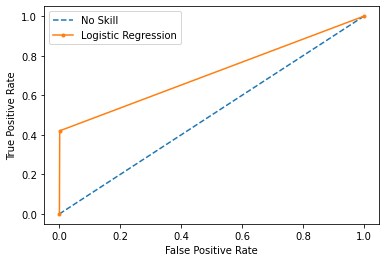

In [41]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = y_pred_lr
# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Neural Network

As our base model we will use a simple logistic regression as our starting point for developing our predictive model.

In [42]:
%%time 

# Class MLPClassifier implements a multi-layer perceptron (MLP) algorithm that trains using Backpropagation.



nn_model = MLPClassifier(random_state=0)

nn_model.fit(X_train, y_train)


Wall time: 10min 36s


MLPClassifier(random_state=0)

In [43]:
# predict against X_test
y_pred = nn_model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [44]:
# Let's save our results in a variable for later use
y_pred_nn = y_pred

# How did our neural network model perform?

print("accuracy: ",accuracy_score(y_test,y_pred_nn))
print("precision_score: ",precision_score(y_test,y_pred_nn))
print("recall_score: ",recall_score(y_test,y_pred_nn))
print("confusion matrix: ")
confusion_matrix(y_test,y_pred_nn)

accuracy:  0.9994981103172383
precision_score:  0.8158236057068742
recall_score:  0.7800744109136006
confusion matrix: 


array([[1905941,     426],
       [    532,    1887]], dtype=int64)

No Skill: ROC AUC=0.500
Neural Network: ROC AUC=0.890


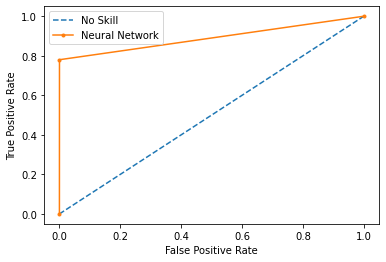

In [45]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = y_pred_nn

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Neural Network: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Neural Network')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [50]:
y_test_lof = tmp_df['isFraud']

tmp_list = []
tmp_dict = {"accuracy":accuracy_score(y_test_lof,y_pred_lof), "precision":precision_score(y_test_lof,y_pred_lof), "recall":recall_score(y_test_lof,y_pred_lof),"roc auc": roc_auc_score(y_test_lof,y_pred_lof)}
tmp_list.append(tmp_dict)
tmp_dict = {"accuracy":accuracy_score(y_test,y_pred_lr), "precision":precision_score(y_test,y_pred_lr), "recall":recall_score(y_test,y_pred_lr),"roc auc": roc_auc_score(y_test,y_pred_lr)}
tmp_list.append(tmp_dict)
tmp_dict = {"accuracy":accuracy_score(y_test,y_pred_nn), "precision":precision_score(y_test,y_pred_nn), "recall":recall_score(y_test,y_pred_nn),"roc auc":roc_auc_score(y_test,y_pred_nn)}
tmp_list.append(tmp_dict)

scores_df = pd.DataFrame(tmp_list)
scores_df.index = ['LocalOutlierFactor','LogisticRegression','NeuralNetworks']
scores_df

,accuracy,precision,recall,roc auc
LocalOutlierFactor,0.917910,0.001965,0.123463,0.521200
LogisticRegression,0.998287,0.352513,0.420422,0.709721
NeuralNetworks,0.999498,0.815824,0.780074,0.889925


# What's next?
- https://en.wikipedia.org/wiki/Collaborative_filtering
- http://recommender-systems.org/collaborative-filtering/
- https://www.geeksforgeeks.org/fuzzywuzzy-python-library/
- https://medium.com/fnplus/evaluating-recommender-systems-with-python-code-ae0c370c90be
- http://surpriselib.com/

## Dataset to try
- https://www.kaggle.com/c/ieee-fraud-detection